In [4]:
import codecs
import io
import os
import re
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [5]:
import requests
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.initializers import Constant
from keras_preprocessing.text import Tokenizer

In [ ]:
# !wget https://ucffc834665fdbf42f8eb5b222bd.dl.dropboxusercontent.com/cd/0/get/A9MONLrM5fGryCxzgKHaRy53fsjmfgd4f-_r2sJjupwLWv4FC6pHFWMzYGqOK_-gGnDQIKcyx-5WJtOidwEvfqIUFa-6QjqJ49uDz7swIkqyOA/file?_download_id=11153375231130913125875909419406850195461780330863375701832421146436&_notify_domain=www.dropbox.com&dl=1

In [ ]:
# import zipfile
# with zipfile.ZipFile('ewe_uni.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/gdrive/My Drive/ECE657')

In [6]:
def clean_text(text_to_clean):
    res = text_to_clean.lower()
    res = re.sub(r"i'm", "i am", res)
    res = re.sub(r"he's", "he is", res)
    res = re.sub(r"she's", "she is", res)
    res = re.sub(r"it's", "it is", res)
    res = re.sub(r"that's", "that is", res)
    res = re.sub(r"what's", "what is", res)
    res = re.sub(r"where's", "where is", res)
    res = re.sub(r"how's", "how is", res)
    res = re.sub(r"\'ll", " will", res)
    res = re.sub(r"\'ve", " have", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"\'d", " would", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"won't", "will not", res)
    res = re.sub(r"can't", "can not", res)
    res = re.sub(r"n't", " not", res)
    res = re.sub(r"n'", "ng", res)
    res = re.sub(r"'bout", "about", res)
    res = re.sub(r"'til", "until", res)
    res = re.sub(r"_comma_", " ", res)
    res = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", res)
    return res

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
# READ EMOTION DATA IN
train_data = pd.read_csv('/content/gdrive/My Drive/ECE657/train.csv')
Prompt = train_data.values[:,3]
Utterance = train_data.values[:,5]

# create question and answer data
questions = []
answers = []

for i in range(1,len(Prompt)):
    if (Prompt[i] == Prompt[i-1]):
        answers.append('<STARTLABEL> '+ clean_text(Utterance[i])+ ' <ENDLABEL>')
        questions.append(clean_text(Utterance[i-1]))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Load validation data
train_data = pd.read_csv('gdrive/My Drive/ECE657/valid.csv')
Prompt = train_data.values[:,3]
Utterance = train_data.values[:,5]

# create question and answer data
val_questions = []
val_answers = []

for i in range(1,len(Prompt)):
    if (Prompt[i] == Prompt[i-1]):
        val_answers.append('<STARTLABEL> '+ clean_text(Utterance[i])+ ' <ENDLABEL>')
        val_questions.append(clean_text(Utterance[i-1]))

In [10]:
for i in range(3):
    print(val_questions[i])
    print(val_answers[i])

today as i was leaving for work in the morning i had a tire burst in the middle of a busy road that scared the hell out of me
<STARTLABEL> are you fine now <ENDLABEL>
are you fine now
<STARTLABEL> yeah i am doing alright now  but with minor injuries <ENDLABEL>
yeah i am doing alright now  but with minor injuries
<STARTLABEL> cool  is your car damaged a lot <ENDLABEL>


In [11]:
np.savetxt('/content/gdrive/My Drive/ECE657/questions.txt', questions, fmt='%s', encoding='utf-8')
np.savetxt('/content/gdrive/My Drive/ECE657/answers.txt', answers, fmt='%s', encoding='utf-8')

In [12]:
np.savetxt('/content/gdrive/My Drive/ECE657/val_questions.txt', questions, fmt='%s', encoding='utf-8')
np.savetxt('/content/gdrive/My Drive/ECE657/val_answers.txt', answers, fmt='%s', encoding='utf-8')

In [13]:
questions = []
answers = []
with open('/content/gdrive/My Drive/ECE657/questions.txt') as f_questions:
    for line in f_questions:
        questions.append(line)
with open('/content/gdrive/My Drive/ECE657/answers.txt') as f_answers:
    for line in f_answers:
        answers.append(line)

In [14]:
val_questions = []
val_answers = []
with open('/content/gdrive/My Drive/ECE657/val_questions.txt') as f_val_questions:
    for line in f_val_questions:
        val_questions.append(line)
with open('/content/gdrive/My Drive/ECE657/val_answers.txt') as f_val_answers:
    for line in f_val_answers:
        val_answers.append(line)

In [15]:
target_regex = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789'

### generate directly from questions and answers lists

In [16]:
def generate_from_lists(questions, answers, batch_size, sample_size):
    batch_idx = 0
    batch_count = sample_size//batch_size
    print('total count', batch_count)
    questions_gen = []
    answers_gen = []
    while batch_idx < batch_count:
        idx_range = range(batch_idx*batch_size, (batch_idx+1)*batch_size) 
        questions_gen = questions[batch_idx*batch_size:(batch_idx+1)*batch_size]
        answers_gen = answers[batch_idx*batch_size:(batch_idx+1)*batch_size]
        yield "".join(questions_gen+answers_gen)
        # print(questions_gen+answers_gen)
        questions_gen = []
        answers_gen = []
        batch_idx += 1

In [17]:
gen_lists = generate_from_lists(questions, answers, 1000, 60000)

In [18]:
# use data generator gen_lists to fit tokenizer
VOCAB_SIZE = 12000
tokenizer = Tokenizer(filters=target_regex, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(gen_lists)
VOCAB_SIZE = VOCAB_SIZE + 1
print('Vocabulary size : {}'.format(VOCAB_SIZE))
print(tokenizer.get_config()['word_counts'])
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

total count 60
Vocabulary size : 12001
{"i": 97089, "remember": 714, "going": 4704, "to": 45070, "see": 2473, "the": 34692, "fireworks": 21, "with": 8130, "my": 24059, "best": 1733, "friend": 2224, "it": 43478, "was": 24035, "first": 1852, "time": 5758, "we": 5584, "ever": 1054, "spent": 196, "alone": 695, "together": 644, "although": 96, "there": 4251, "a": 39212, "lot": 2621, "of": 17701, "people": 2916, "felt": 1511, "like": 7507, "only": 1398, "in": 13853, "world": 506, "this": 4421, "you": 38698, "were": 3828, "love": 2497, "or": 3248, "just": 8548, "miss": 855, "her": 5197, "where": 1534, "has": 2227, "she": 7824, "gone": 443, "no": 6371, "longer": 153, "talk": 556, "feels": 403, "hitting": 61, "blank": 11, "wall": 53, "when": 6185, "darkness": 6, "oh": 7832, "ya": 129, "do": 14713, "not": 21135, "really": 7722, "how": 5706, "dont": 667, "feel": 4102, "so": 16846, "its": 2301, "wonder": 167, "actually": 878, "hit": 593, "walls": 27, "times": 807, "but": 11349, "get": 7220, "by": 

In [19]:
maxlen_ques=114
maxlen_ans=119
# preprocess the data beforehand instead of processing in real time
questions_tokenized = tokenizer.texts_to_sequences(questions)
encoder_input = pad_sequences(questions_tokenized, maxlen=maxlen_ques, padding='post')

answers_tokenized = tokenizer.texts_to_sequences(answers)
decoder_input = pad_sequences(answers_tokenized, maxlen=maxlen_ans, padding='post')

# remove <startlabel> in tokenized answers
for i in range(len(answers_tokenized)):
    answers_tokenized[i] = answers_tokenized[i][1:]
padded_answers = pad_sequences(answers_tokenized, maxlen=maxlen_ans, padding='post')

In [20]:
val_questions_tokenized = tokenizer.texts_to_sequences(val_questions)
val_encoder_input = pad_sequences(val_questions_tokenized, maxlen=maxlen_ques, padding='post')

val_answers_tokenized = tokenizer.texts_to_sequences(val_answers)
val_decoder_input = pad_sequences(val_answers_tokenized, maxlen=maxlen_ans, padding='post')

# remove <start> in tokenized answers
for i in range(len(val_answers_tokenized)):
    val_answers_tokenized[i] = val_answers_tokenized[i][1:]
val_padded_answers = pad_sequences(val_answers_tokenized, maxlen=maxlen_ans, padding='post')

In [21]:
def data_generator(encoder_input, decoder_input, pad_ans, batch_size, sample_size, vocab_size, tokenizer):
    batch_idx = 0
    batch_count = sample_size//batch_size
    print('batches in one epoch', batch_count)

    while batch_idx < batch_count:
        
        questions_gen = questions[batch_idx*batch_size:(batch_idx+1)*batch_size]
        answers_gen = answers[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        encoder_input_data = encoder_input[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        decoder_input_data = decoder_input[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        padded_answers = pad_ans[batch_idx*batch_size:(batch_idx+1)*batch_size]
        decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE, dtype=np.int8)
        
        yield ([encoder_input_data, decoder_input_data], decoder_output_data)

        batch_idx += 1
        if batch_idx == batch_count:
            print('\nreaches the end of training set')
            batch_idx = 0
            # shuffle the dataset while keeping the three lists in the same order
            random.seed(1)
            random.shuffle(encoder_input_data)
            random.seed(1)
            random.shuffle(decoder_input_data)
            random.seed(1)
            random.shuffle(padded_answers)

In [22]:
SAMPLE_SIZE = 30000
BATCH_SIZE = 128
train_gen = data_generator(encoder_input, decoder_input, padded_answers, BATCH_SIZE, SAMPLE_SIZE, VOCAB_SIZE, tokenizer)
print(train_gen)

<generator object data_generator at 0x7f64f8802d58>


In [23]:
def val_data_generator(encoder_input, decoder_input, pad_ans, batch_size, sample_size, vocab_size, tokenizer):
    batch_idx = 0
    batch_count = sample_size//batch_size
    print('\nbatches in one epoch', batch_count)

    while batch_idx < batch_count:
        
        questions_gen = questions[batch_idx*batch_size:(batch_idx+1)*batch_size]
        answers_gen = answers[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        encoder_input_data = encoder_input[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        decoder_input_data = decoder_input[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        padded_answers = pad_ans[batch_idx*batch_size:(batch_idx+1)*batch_size]
        decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE, dtype=np.int8)
        
        yield ([encoder_input_data, decoder_input_data], decoder_output_data)

        batch_idx += 1
        if batch_idx == batch_count:
            print('\nreaches the end of validation set')
            batch_idx = 0
            # shuffle the dataset while keeping the three lists in the same order
            random.seed(1)
            random.shuffle(encoder_input_data)
            random.seed(1)
            random.shuffle(decoder_input_data)
            random.seed(1)
            random.shuffle(padded_answers)

In [24]:
VAL_SAMPLE_SIZE = 2000
VAL_BATCH_SIZE = 32
val_gen = val_data_generator(val_encoder_input, val_decoder_input, val_padded_answers, 
                         VAL_BATCH_SIZE, VAL_SAMPLE_SIZE, VOCAB_SIZE, tokenizer)
print(val_gen)

<generator object val_data_generator at 0x7f64f35b0b48>


In [25]:
# first, build index mapping words in the embeddings set to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open('/content/gdrive/My Drive/ECE657/ewe_uni.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 183712 word vectors.


In [26]:
# prepare embedding matrix
word_index = tokenizer.word_index
num_words = VOCAB_SIZE
embedding_matrix = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i >= 12001:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [27]:
# encoder will be used to capture space-dependent 
# relations between words from the questions
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 300, mask_zero=True, trainable=True, embeddings_initializer=Constant(embedding_matrix))(enc_inputs)
#enc_embedding = Embedding(VOCAB_SIZE, 300, mask_zero=True, trainable=True)(enc_inputs)
enc_lstm = LSTM(300, return_state=True)
enc_lstm. _could_use_gpu_kernel = False
enc_outputs, state_h, state_c = enc_lstm(enc_embedding)
enc_states = [state_h, state_c]

In [28]:
# decoder will be used to capture space-dependent relations 
# between words from the answers using encoder's 
# internal state as a context
dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 300, mask_zero=True, trainable=True, embeddings_initializer=Constant(embedding_matrix))(dec_inputs)
#dec_embedding = Embedding(VOCAB_SIZE, 300, mask_zero=True, trainable=True)(dec_inputs)
dec_lstm = LSTM(300, return_state=True, return_sequences=True)
dec_lstm. _could_use_gpu_kernel = False
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)

In [29]:
# decoder is connected to the output Dense layer
dec_dense = Dense(VOCAB_SIZE, activation=softmax)
output = dec_dense(dec_outputs)

In [30]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    3600300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    3600300     input_2[0][0]                    
_______________________________________________________________________________________

In [31]:
History = model.fit(train_gen, steps_per_epoch=SAMPLE_SIZE//BATCH_SIZE, initial_epoch=0, epochs=70, 
          validation_data=val_gen, validation_steps=VAL_SAMPLE_SIZE//VAL_BATCH_SIZE)

batches in one epoch 234
Epoch 1/70
233/234 [============================>.] - ETA: 0s - loss: 0.6311
reaches the end of training set
234/234 [==============================] - ETA: 0s - loss: 0.6314
batches in one epoch 62

reaches the end of validation set
234/234 [==============================] - 225s 960ms/step - loss: 0.6314 - val_loss: 0.6096
Epoch 2/70
233/234 [============================>.] - ETA: 0s - loss: 0.5382
reaches the end of training set
234/234 [==============================] - ETA: 0s - loss: 0.5421
reaches the end of validation set
234/234 [==============================] - 225s 961ms/step - loss: 0.5421 - val_loss: 0.5687
Epoch 3/70
233/234 [============================>.] - ETA: 0s - loss: 0.5094
reaches the end of training set
234/234 [==============================] - ETA: 0s - loss: 0.5135
reaches the end of validation set
234/234 [==============================] - 222s 949ms/step - loss: 0.5135 - val_loss: 0.5471
Epoch 4/70
233/234 [========================

In [32]:
import json
with open('/content/gdrive/My Drive/ECE657/seq2seq_EWE_V2_30000.log', 'w') as f:
    json.dump(History.history, f)

In [33]:
model.save_weights("/content/gdrive/My Drive/ECE657/seq2seq_EWE_V2_epoch70_units300.h5")

In [34]:
model.load_weights("/content/gdrive/My Drive/ECE657/seq2seq_EWE_V2_epoch70_units300.h5")

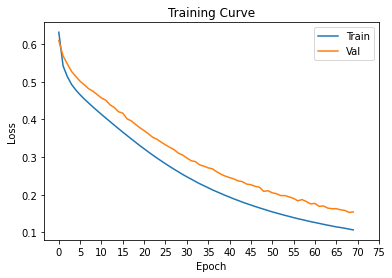

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Training Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75])
plt.savefig("/content/gdrive/My Drive/ECE657/EWE_V2_Loss.png")
plt.show()

In [ ]:
model.load_weights("/content/gdrive/My Drive/seq2seq_ewe_epoch100.h5")

In [ ]:
def make_inference_models():
    # two inputs for the state vectors returned by encoder
    dec_state_input_h = Input(shape=(300,))
    dec_state_input_c = Input(shape=(300,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    # these state vectors are used as an initial state 
    # for LSTM layer in the inference decoder
    # third input is the Embedding layer as explained above   
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding, initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    # Dense layer is used to return OHE predicted word
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(inputs=[dec_inputs] + dec_states_inputs, outputs=[dec_outputs] + dec_states)
   
    # single encoder input is a question, represented as a sequence 
    # of integers padded with zeros
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
   
    return enc_model, dec_model

In [ ]:
enc_model, dec_model = make_inference_models()

In [ ]:
def str_to_tokens(sentence):
    clean_sentence = clean_text(sentence)
    question_tokenized = tokenizer.texts_to_sequences([clean_sentence])
    return pad_sequences(question_tokenized, maxlen=maxlen_ques, padding='post')

### Functions for answer prediction and evaluation

In [ ]:
# get the predicted answer output one word after another until end is predicted or maxlen is reached

# function to predict answer with probability matrix
def predict_answer(input_question):
    states_values = enc_model.predict(str_to_tokens(input_question))
    # start with a target sequence of size 1 - word 'start'   
    empty_target_seq = np.array([2])
    stop_condition = False

    # store the one hot probability vector for each word in ans_prob
    # store the sequence of words in predicted answer in word_idx_seq
    ans_prob = []
    word_idx_seq = []
    decoded_ans = ''

    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values) 
        sampled_word_index = np.argmax(dec_outputs[0, 0, :])
        # print(ans_prob)
        word = reverse_word_map.get(sampled_word_index)
        if word == 'endlabel' or len(word_idx_seq) > maxlen_ans:
            stop_condition = True
            break

        word_idx_seq.append(sampled_word_index)
        ans_prob.append(dec_outputs[0, 0, :])    
        # assign the predicted word index as the next step input for decoder and update state values
        empty_target_seq = np.array([sampled_word_index])
        states_values = [h, c]
    
    word_list = [reverse_word_map.get(i, "") for i in word_idx_seq]
    ans_prob = np.array(ans_prob)
    ans_output = " ".join(word_list)

    return ans_output, word_idx_seq, ans_prob

In [ ]:
def onehot_expect_answer(expected_ans, len_predict):

    expected_ans = clean_text(expected_ans)
    expected_ans_tokenized = tokenizer.texts_to_sequences([expected_ans])

    len_expected = len(expected_ans_tokenized[0])

    # limit the length of perplexity calculation to the number of predicted words
    ans_word_num = len_predict

    # if predicted word_length is larger than expected, pad the expected answer to the length of prediction
    # if predicted word_length is less than expected, cut the expected answer to be the same as the length of prediction
    if len_predict > len_expected:
        expected_ans_adj = pad_sequences(expected_ans_tokenized, maxlen=ans_word_num, padding='post')[0]
    else:
        expected_ans_adj = expected_ans_tokenized[0][:ans_word_num]
        # print(expected_ans_adj)

    onehot_expected = to_categorical([expected_ans_adj], VOCAB_SIZE, dtype=np.int8)[0]
    # print(onehot_expected.shape)
    # print(ans_prob.shape)
    return onehot_expected, ans_word_num

In [ ]:
def compute_cross_entropy(onehot_expected, ans_prob, ans_word_num):
    print(onehot_expected.shape)
    print(ans_prob.shape)
    weights = [1/ans_word_num] * ans_word_num
    cce = CategoricalCrossentropy()
    cross_entropy = cce(onehot_expected, ans_prob, sample_weight=tf.constant(weights)).numpy()
    return cross_entropy

In [ ]:
input_question = 'yeah i am doing alright now  but with minor injuries'
answer, word_idx_seq, ans_prob = predict_answer(input_question)
print(ans_prob.shape)
expected_ans = 'are you fine now'

onehot_expected, ans_word_num = onehot_expect_answer(expected_ans, len(word_idx_seq))
print(onehot_expected.shape)
loss = compute_cross_entropy(onehot_expected, ans_prob, ans_word_num)
print(loss)

TypeError: ignored

#### Note: better to change the comma to " " (space instead of null) in the clean_text function used for cleaning training set
Also replace `<START>` and `<END>` with `<STARTLABEL>` and `<ENDLABEL>` as 'start' and 'end' are actually meaningful words

In [ ]:
# Load validation data
train_data = pd.read_csv('/content/gdrive/My Drive/ECE657/valid.csv')
Prompt = train_data.values[:,3]
Utterance = train_data.values[:,5]

# create question and answer data
val_questions = []
val_answers = []

for i in range(1,len(Prompt)):
    if (Prompt[i] == Prompt[i-1]):
        val_answers.append(clean_text(Utterance[i]))
        val_questions.append(clean_text(Utterance[i-1]))

#### Note: the loaded model was trained on the data transformed by a tokenizer with larger vocab_size, so if the question contains a word with token larger than 12000, then the prediction would go wrong. Retrain the model would solve the issue

In [ ]:
for i in range(0,20):
    print(i)
    print('question:', val_questions[i])
    answer, word_idx_seq, ans_prob = predict_answer(val_questions[i])
    print('predicted output:', answer)
    print('expected output:', val_answers[i])
    onehot_expected, ans_word_num = onehot_expect_answer(val_answers[i], len(word_idx_seq))
    loss = compute_cross_entropy(onehot_expected, ans_prob, ans_word_num)
    print('cross entropy loss:', loss)
    print('\n')

12
question: i see  glad he is ok
predicted output: i am glad you are feeling better now
expected output: yeah  he had just drank a bottle  and i was moving him around like an airplane in retrospect i deserved it
[70, 28, 46, 30, 2064, 6, 2318, 11, 1, 13, 588, 66, 191, 38, 86, 2832, 21, 1, 1379, 5]
(8, 12001)
(8, 12001)
cross entropy loss: 1.2586328


13
question: hi  how are you
predicted output: i am i am just so nervous about it going back too far if you are nervous about it but i think it will be worth it in the
expected output: hello
(29, 12001)
(29, 12001)
cross entropy loss: 0.5104623


14
question: im doing great i just wanted to tell you a short story about a time i helped an elderly lady  she was struggling to carry her bags from a trip she had took  i helped her carry them to her door  pretty good feeling when you help others 
predicted output: oh envious then do not you want to be with them what is the yeah the forward
expected output: hi  how are you
(17, 12001)
(17, 12001

### Note: if the number of words in predicted and expected answers are significantly different, then the cross_entropy loss would be very large. 
The reason is that I take the length of predicted answer to be the baseline, if the expected answer is much shorter, then it would be padded with zeros in the end, therefore increasing the loss significantly.

In [ ]:
def compute_perplexity(questions, answers):
    if len(questions) != len(answers):
        print('the number of questions does not match the number of answers!')
        return
    loss_list = []
    for i in range(len(questions)):
        print('question:', questions[i])
        answer, word_idx_seq, ans_prob = predict_answer(questions[i])
        print('predicted output:', answer)
        print('expected output:', answers[i])
        onehot_expected, ans_word_num = onehot_expect_answer(answers[i], len(word_idx_seq))
        loss = compute_cross_entropy(onehot_expected, ans_prob, ans_word_num)
        loss_list.append(loss)
        print('cross entropy loss:', loss)
        print('\n')
    average_loss = np.mean(loss_list)
    print('average cross entropy loss: ', average_loss)
    return 2 ** average_loss

In [ ]:
print('perplexity:', compute_perplexity(val_questions[12:20], val_answers[12:20]))

question: i see  glad he is ok
predicted output: i am glad you are feeling better now
expected output: yeah  he had just drank a bottle  and i was moving him around like an airplane in retrospect i deserved it
[70, 28, 46, 30, 2064, 6, 2318, 11, 1, 13, 588, 66, 191, 38, 86, 2832, 21, 1, 1379, 5]
(8, 12001)
(8, 12001)
cross entropy loss: 1.2586328


question: hi  how are you
predicted output: i am i am just so nervous about it going back too far if you are nervous about it but i think it will be worth it in the
expected output: hello
(29, 12001)
(29, 12001)
cross entropy loss: 0.5104623


question: im doing great i just wanted to tell you a short story about a time i helped an elderly lady  she was struggling to carry her bags from a trip she had took  i helped her carry them to her door  pretty good feeling when you help others 
predicted output: oh envious then do not you want to be with them what is the yeah the forward
expected output: hi  how are you
(17, 12001)
(17, 12001)
cross e

In [ ]:
for _ in range(5):
    # encode the input sequence into state vectors
    answer, word_idx_seq, ans_prob = predict_answer(input('Enter question : '))
    print(answer)

Enter question : are you a happy robot


TypeError: ignored

In [ ]:
# expected_ans = 'Yes but if you stay calm it will be ok.'
# expected_ans = clean_text(expected_ans)
# print(expected_ans)
# expected_ans_tokenized = tokenizer.texts_to_sequences([expected_ans])
# print(expected_ans_tokenized)
# print(len(expected_ans_tokenized[0]))
# expected_ans_padded = pad_sequences(expected_ans_tokenized, maxlen=maxlen_ans, padding='post')
# print(expected_ans_padded)

In [ ]:
# # predicted output sentence is A B C 0 0
# pred = [[0.05, 0.9, 0.05, 0], [0.1, 0.2, 0.6, 0.1], [0.05, 0.05, 0.1, 0.8], [0.6, 0.2, 0.1, 0.1], [0.8, 0.1, 0, 0.1]]
# # expected output sentence is A A C 0 0 
# true = [[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]

In [ ]:
# cce = CategoricalCrossentropy()
# print(cce(true, pred, sample_weight=tf.constant([0.2, 0.2, 0.2, 0.2, 0.2])).numpy())
# print(cce(true, pred).numpy())

0.25021723
1.251086


In [ ]:
# num_words = 5
# const = [1/num_words] * num_words
# print(const)

[0.2, 0.2, 0.2, 0.2, 0.2]


In [ ]:
# cce = CategoricalCrossentropy()
# print(cce(true, pred, sample_weight=tf.constant(const)).numpy())
# print(cce(true, pred).numpy())

0.25021723
1.251086
